In [184]:
from pathlib import Path

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pearl.post_processing.bmi import calc_risk_by_group, clean_control


In [185]:
baseline = Path("/workspaces/pearlModel/out/S0_SA_10/combined")
variable = Path("/workspaces/pearlModel/out/S3_SA_10/combined")

In [186]:
param_df_baseline = pd.read_parquet(baseline / "parameters.parquet").reset_index(drop=True)
param_df_variable = pd.read_parquet(variable / "parameters.parquet").reset_index(drop=True)

In [187]:
param_df_baseline.columns

Index(['replication', 'group', 'new_dx', 'final_year', 'mortality_model',
       'mortality_threshold_flag', 'idu_threshold', 'seed',
       'bmi_intervention_scenario', 'bmi_intervention_start_year',
       'bmi_intervention_end_year', 'bmi_intervention_coverage',
       'bmi_intervention_effectiveness', 'prev_users_dict_hcv',
       'prev_users_dict_smoking', 'prev_users_dict_anx', 'prev_users_dict_dpr',
       'prev_users_dict_ckd', 'prev_users_dict_lipid', 'prev_users_dict_dm',
       'prev_users_dict_ht', 'prev_users_dict_malig', 'prev_users_dict_esld',
       'prev_users_dict_mi', 'prev_inits_dict_hcv', 'prev_inits_dict_smoking',
       'prev_inits_dict_anx', 'prev_inits_dict_dpr', 'prev_inits_dict_ckd',
       'prev_inits_dict_lipid', 'prev_inits_dict_dm', 'prev_inits_dict_ht',
       'prev_inits_dict_malig', 'prev_inits_dict_esld', 'prev_inits_dict_mi',
       'sa_incidence_shift_dm', 'pre_art_bmi', 'post_art_bmi'],
      dtype='object')

In [188]:
bmi_int_dm_prev_variable = pd.read_parquet(variable / "bmi_int_dm_prev.parquet")
bmi_int_dm_prev_baseline = pd.read_parquet(baseline / "bmi_int_dm_prev.parquet")

# clean to control specifications
control_bmi_int_dm_prev_variable = clean_control(bmi_int_dm_prev_variable, only_eligible=True)
control_bmi_int_dm_prev_baseline = clean_control(bmi_int_dm_prev_baseline, only_eligible=True)

# filter for only people eligible for intervention
bmi_int_eligible_risk_variable = calc_risk_by_group(control_bmi_int_dm_prev_variable, 7).compute()
bmi_int_eligible_risk_baseline = calc_risk_by_group(control_bmi_int_dm_prev_baseline, 7).compute()

In [189]:
num_samples = 10
baseline_risk = bmi_int_eligible_risk_baseline.groupby('group').sample(num_samples, replace=True).reset_index()
variable_risk = bmi_int_eligible_risk_variable.groupby('group').sample(num_samples, replace=True).reset_index()

In [190]:
risk_df = pd.DataFrame(variable_risk['risk'] - baseline_risk['risk'])
risk_df['group'] = baseline_risk['group']

In [191]:
baseline_risk_df = risk_df.groupby('group').median().reset_index()

In [192]:
baseline_risk_df

,group,risk
0,het_black_female,-0.019303
1,het_black_male,-0.021848
2,het_hisp_female,0.001695
3,het_hisp_male,0.014787
4,het_white_female,0.024278
5,het_white_male,-0.214361
6,idu_black_female,0.144866
7,idu_black_male,-0.004875
8,idu_hisp_female,-0.031596
9,idu_hisp_male,0.000342


In [193]:
def calc_tornado_vals(baseline_risk_df, variable_risk_df, param_df_baseline, param_df_variable, col_name, num_samples=10):
    
    sub_param_baseline = param_df_baseline[['replication', 'group', col_name]]
    sub_param_variable = param_df_variable[['replication', 'group', col_name]]
    
    baseline_merged = sub_param_baseline.merge(baseline_risk_df, on=['replication', 'group'], how='left').fillna(0)
    variable_merged = sub_param_variable.merge(variable_risk_df, on=['replication', 'group'], how='left').fillna(0)
    
    quantile_val_baseline = baseline_merged.groupby('group')[col_name].quantile([0.25, 0.75]).unstack().reset_index()
    quantile_val_variable = variable_merged.groupby('group')[col_name].quantile([0.25, 0.75]).unstack().reset_index()
    
    tornado_df = []
    for group in quantile_val_baseline['group'].unique():
        group_df_baseline = baseline_merged[baseline_merged['group'] == group]
        group_df_variable = variable_merged[variable_merged['group'] == group]

        lesser_val_baseline = quantile_val_baseline[quantile_val_baseline['group'] == group][0.25].values[0]
        greater_val_baseline = quantile_val_baseline[quantile_val_baseline['group'] == group][0.75].values[0]
        lesser_val_variable = quantile_val_variable[quantile_val_variable['group'] == group][0.25].values[0]
        greater_val_variable = quantile_val_variable[quantile_val_variable['group'] == group][0.75].values[0]
        
        lesser_group_df_baseline = group_df_baseline[group_df_baseline[col_name] <= lesser_val_baseline].sample(num_samples, replace=True).reset_index()
        greater_group_df_baseline = group_df_baseline[group_df_baseline[col_name] >= greater_val_baseline].sample(num_samples, replace=True).reset_index()
        lesser_group_df_variable = group_df_variable[group_df_variable[col_name] <= lesser_val_variable].sample(num_samples, replace=True).reset_index()
        greater_group_df_variable = group_df_variable[group_df_variable[col_name] >= greater_val_variable].sample(num_samples, replace=True).reset_index()
        
        group_tornado_df = {
            'group': group,
            'variable': col_name,
            0.25: (lesser_group_df_variable['risk'] - lesser_group_df_baseline['risk']).median(),
            0.75: (greater_group_df_variable['risk'] - greater_group_df_baseline['risk']).median()
        }
        tornado_df.append(group_tornado_df)
        
    tornado_df = pd.DataFrame(tornado_df)
    return tornado_df

In [194]:
target_columns = ['prev_users_dict_dm', 'prev_inits_dict_dm', 'sa_incidence_shift_dm', 'pre_art_bmi', 'post_art_bmi']

In [195]:
tornado_vals = []
for col in target_columns:
    tornado_vals.append(calc_tornado_vals(bmi_int_eligible_risk_baseline, bmi_int_eligible_risk_variable, param_df_baseline, param_df_variable, col))
tornado_vals = pd.concat(tornado_vals).reset_index(drop=True)

In [196]:
tornado_vals

,group,variable,0.25,0.75
0,het_black_female,prev_users_dict_dm,0.242829,0.002319
1,het_black_male,prev_users_dict_dm,0.078259,-0.097658
2,het_hisp_female,prev_users_dict_dm,0.095282,-0.022052
3,het_hisp_male,prev_users_dict_dm,-0.137876,0.200657
4,het_white_female,prev_users_dict_dm,-0.006996,0.247004
...,...,...,...,...
70,idu_white_female,post_art_bmi,0.184369,0.095238
71,idu_white_male,post_art_bmi,0.064377,0.176021
72,msm_black_male,post_art_bmi,-0.217180,-0.000634
73,msm_hisp_male,post_art_bmi,-0.034039,-0.076339


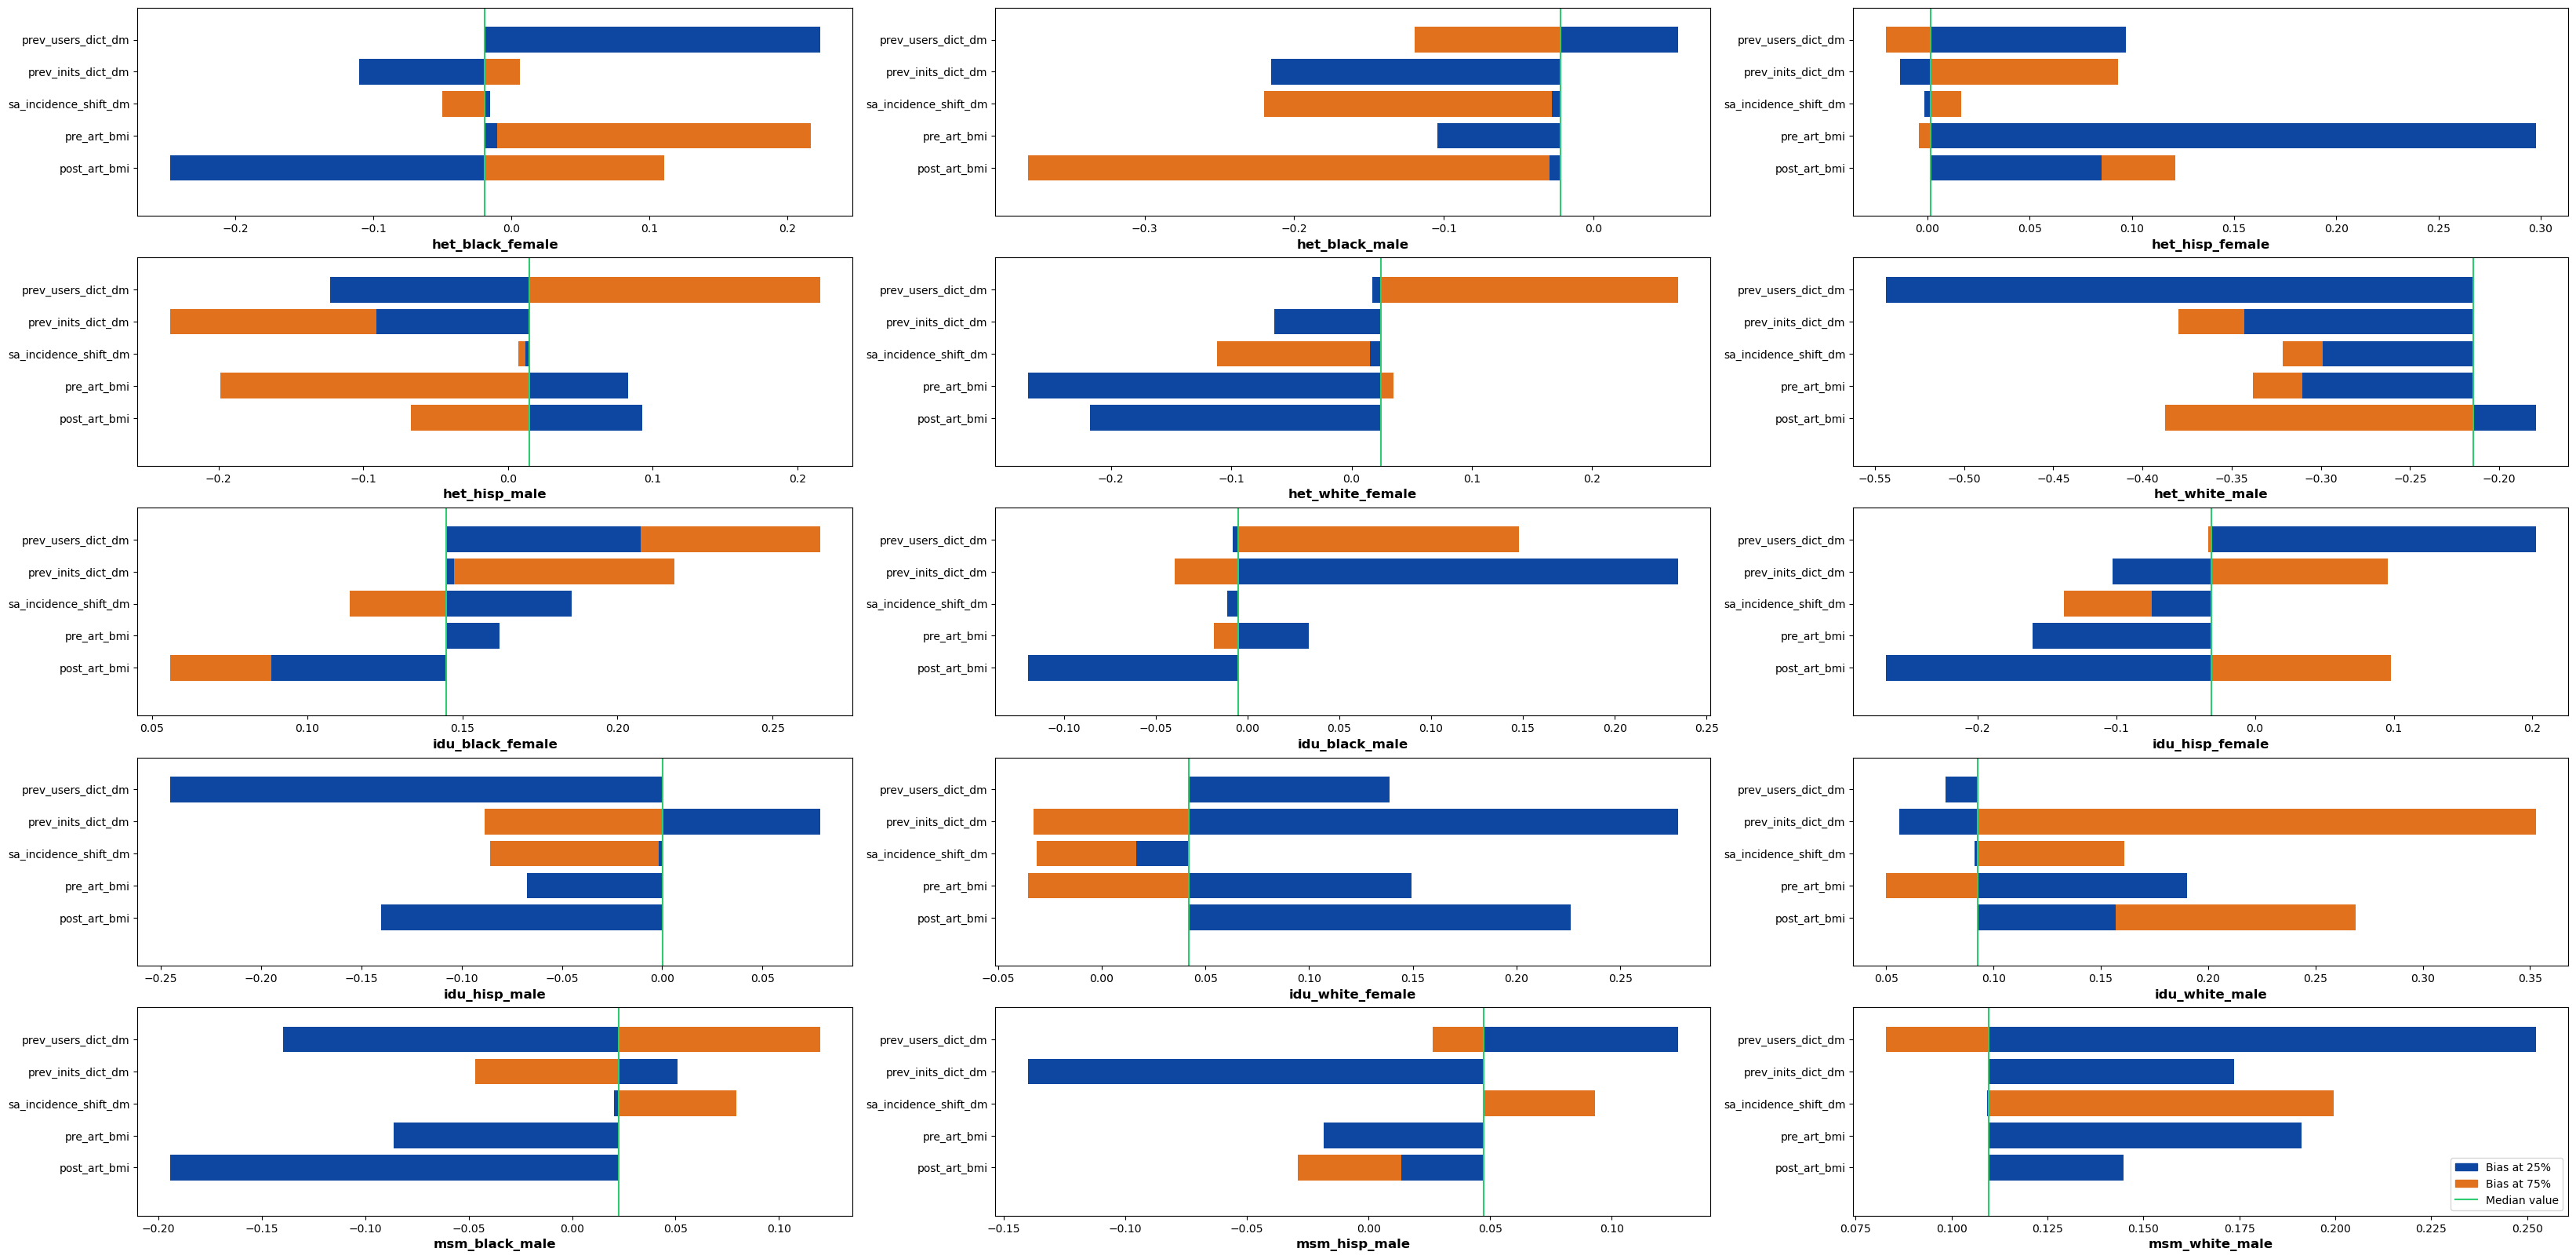

In [197]:
fig, axs = plt.subplots(5, 3, figsize=(40, 20))

plot_groups = np.sort(tornado_vals.group.unique())

for i, group in enumerate(plot_groups):
    
    group_vals = tornado_vals[tornado_vals['group']==group].reset_index(drop=True)
    ax = axs.flatten()[i]
    
    # plot parameters
    yTick_label = group_vals['variable']
    ys = range(len(yTick_label))[::-1]
    height = 0.8
    
    color_5 = '#0d47a1'
    color_95 = '#e2711d'
    color_line = '#2ECC71'

    # Data to be visualized
    value_25 = group_vals.iloc[:,2].values
    value_75 = group_vals.iloc[:,3].values
    base = baseline_risk_df[baseline_risk_df['group']==group]['risk'].values[0]

    # Draw bars for 75%
    for y, value2 in zip(ys, value_75):
        ax.broken_barh([(base, value2)], (y - height/2, height),facecolors=[color_95,color_95])

    # Draw bars for 25%
    for y, value in zip(ys, value_25):
        ax.broken_barh([(base, value)], (y - height/2,height), facecolors=[color_5,color_5])

    # Add vertical line for median value
    ax.axvline(base, color=color_line, linewidth=1.5, label='Median value')  

    # Modify the graph
    ax.set_ylim([-1.5, 5])
    ax.set_yticks(ys)
    ax.set_yticklabels(yTick_label)
    ax.set_xlabel(group, fontsize=12, fontweight='bold')

    # Add legend
    handles = [Patch(color=color_5, label='Bias at 25%'), Patch(color=color_95, label='Bias at 75%'),
            Line2D([0], [0], color=color_line, linewidth=1.5, label='Median value')]
    plt.legend(handles=handles, loc='lower right')
